## Foraging Analyses
This script is inspired by analyses from "Professional Jazz Musicians Explore and Exploit a Space of Sounds" (Williams et al., 2024) and examines euclidean distance and cosine similarity patterns across all transcripts.

**Author:** Helen Schmidt  
**Python version:** 3.11.13

In [1]:
import os
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

/opt/anaconda3/envs/myenv-python3-11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define data input location
input_dir = "/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/CANDOR/transcripts/raw"
# define data output location
output_dir = "/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/full-sample"

In [3]:
# load data
df = pd.read_pickle(output_dir + "/full_sample_tile_3_0.pkl")
df.head()

,transcript_id,window_size,gap_size,A_start_turn,A_end_turn,A_utterances,A_embeddings,B_start_turn,B_end_turn,B_utterances,B_embeddings,cosine_similarity,euclidean_distance
0,0020a0c5-1658-4747-99c1-2839e736b481,3,0,1,3,"No, I'm good. How are you? No. Hi, how are you...","[[0.012172122, -0.011064016, 0.06654317, 0.000...",4,6,"Hm My name is played to me Hi, my name's Amand...","[[-0.03531422, -0.04561006, 0.02838244, -0.076...",0.315577,1.169977
1,0020a0c5-1658-4747-99c1-2839e736b481,3,0,2,4,"No. Hi, how are you? Good thanks. Hm My name i...","[[-0.0106563475, -0.06792329, 0.064656146, -0....",5,7,"Hi, my name's Amanda. and the next time you Am...","[[-0.0010068159, -0.09045196, -0.0003150229, -...",0.387075,1.107181
2,0020a0c5-1658-4747-99c1-2839e736b481,3,0,3,5,"Good thanks. Hm My name is played to me Hi, my...","[[-0.038483433, -0.0698858, 0.0062682955, -0.0...",6,8,and the next time you Amanda. All right. Does ...,"[[0.044995096, -0.058201604, -0.028326219, -0....",0.442343,1.056084
3,0020a0c5-1658-4747-99c1-2839e736b481,3,0,4,6,"Hm My name is played to me Hi, my name's Amand...","[[-0.03531422, -0.04561006, 0.02838244, -0.076...",7,9,"All right. Does that time start? Yeah, three o...","[[0.043147173, -0.042117808, -0.027217342, -0....",0.176185,1.283600
4,0020a0c5-1658-4747-99c1-2839e736b481,3,0,5,7,"Hi, my name's Amanda. and the next time you Am...","[[-0.0010068159, -0.09045196, -0.0003150229, -...",8,10,"right. At three. Right, What's that? Don't go ...","[[0.043233756, -0.056193333, -0.049202096, -0....",0.408750,1.087428


### Step Size & Turn Angle

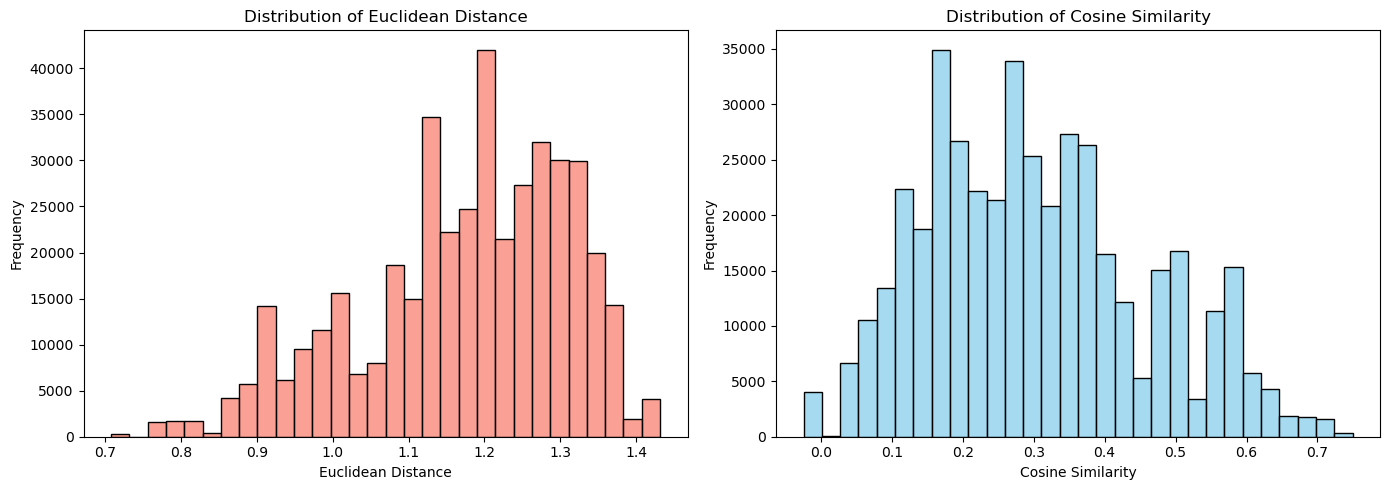

In [5]:
# plot distributions of cosine similarity and euclidean distances
# create figure / axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# plot A - step length (euclidean distance)
sns.histplot(df['euclidean_distance'], bins=30, kde=False, ax=axes[0], color='salmon')
axes[0].set_title('Distribution of Euclidean Distance')
axes[0].set_xlabel('Euclidean Distance')
axes[0].set_ylabel('Frequency')

# plot B - turn angles (cosine similarity)
sns.histplot(df['cosine_similarity'], bins=30, kde=False, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of Cosine Similarity')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# plot
plt.tight_layout()
plt.show()

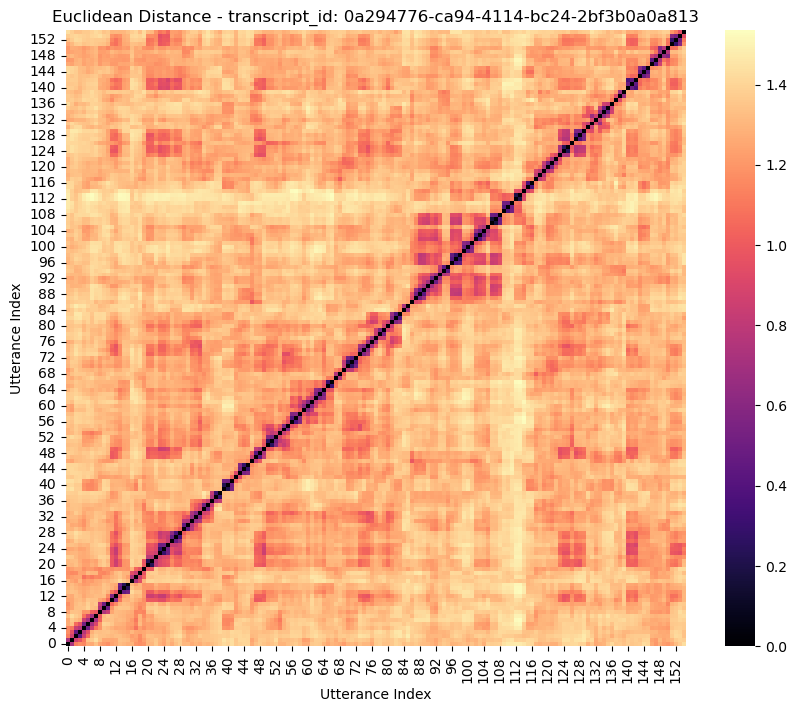

In [4]:
transcript_id = '0a294776-ca94-4114-bc24-2bf3b0a0a813'
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

embedding_matrix = np.vstack(subset['A_embeddings'].values)

distance_matrix = cdist(embedding_matrix, embedding_matrix, metric='euclidean')

plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, cmap='magma')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.gca().invert_yaxis()
plt.xlabel('Utterance Index')
plt.ylabel('Utterance Index')
plt.show()

In [15]:
# test subset
test_df = df.head(1000).copy()

# create a folder in the full sample data output to save heatmaps
heatmap_dir = os.path.join(output_dir, "euclidean-distance-heatmaps")
os.makedirs(heatmap_dir, exist_ok=True)

# loop through each unique transcript_id
for transcript_id in df['transcript_id'].unique():
    subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)
    # add in skip if not enough data exists to compute distances
    if subset.empty or subset.shape[0] < 2:
        continue
    try:
        # stack embeddings into a matrix
        embedding_matrix = np.vstack(subset['A_embeddings'].values)
        # compute pairwise euclidean distance
        distance_matrix = cdist(embedding_matrix, embedding_matrix, metric = "euclidean")
        # plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(distance_matrix, annot=False, cmap='magma')
        plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
        plt.gca().invert_yaxis()
        plt.xlabel('Utterance Index')
        plt.ylabel('Utterance Index')
        # save each plot
        save_id = transcript_id.replace('/', '_')  # edit ID in case there are problematic characters
        plot_path = os.path.join(heatmap_dir, f"{save_id}.png")
        plt.savefig(plot_path, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Error creating heatmap for {transcript_id}: {e}")

In [17]:
# test subset
test_df = df.head(1000).copy()

# create a folder in the full sample data output to save heatmaps
heatmap_dir = os.path.join(output_dir, "cosine-similarity-heatmaps")
os.makedirs(heatmap_dir, exist_ok=True)

# loop through each unique transcript_id
for transcript_id in df['transcript_id'].unique():
    subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)
    # add in skip if not enough data exists to compute distances
    if subset.empty or subset.shape[0] < 2:
        continue
    try:
        # stack embeddings into a matrix
        embedding_matrix = np.vstack(subset['A_embeddings'].values)
        # compute pairwise cosine similarity
        distance_matrix = cdist(embedding_matrix, embedding_matrix, metric = "cosine")
        # plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(distance_matrix, annot=False, cmap='magma')
        plt.title(f'Cosine Similarity - transcript_id: {transcript_id}')
        plt.gca().invert_yaxis()
        plt.xlabel('Utterance Index')
        plt.ylabel('Utterance Index')
        # save each plot
        save_id = transcript_id.replace('/', '_')  # edit ID in case there are problematic characters
        plot_path = os.path.join(heatmap_dir, f"{save_id}.png")
        plt.savefig(plot_path, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Error creating heatmap for {transcript_id}: {e}")

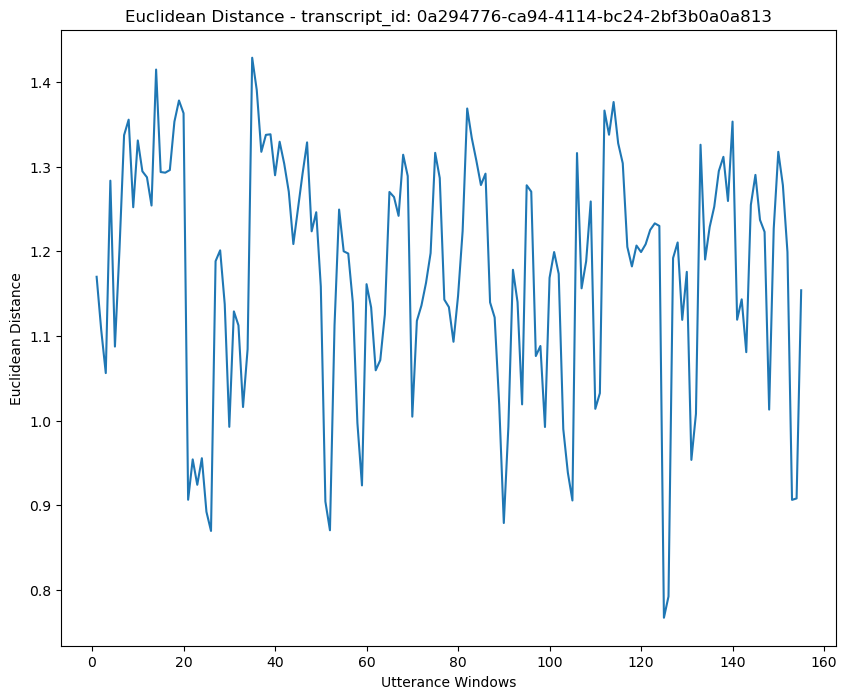

In [7]:
# plot a conversation's peaks of euclidean distances and cosine similarities
transcript_id = '0a294776-ca94-4114-bc24-2bf3b0a0a813'
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.lineplot(data=subset, x='A_start_turn', y='euclidean_distance')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.xlabel('Utterance Windows')
plt.ylabel('Euclidean Distance')
plt.show()

## Data checks

*Check number of annotated transcripts, see if there are any IDs that don't have an annotator*

### Foote Novelty

*To Do:*
1) look at peaks in distances across conversations to figure out foote novelty thresholds
2) take cosine of the angle between vectors (e.g., the distance between cosine of window 1 and window 2 and cosine of window 2 and window 3)


Do we just combine utterances from 1/2 and 2/3 to find distance between sets?
find periods where the similarity between windows is greater than similarity within